<a href="https://colab.research.google.com/github/wisawapan/Automatic-email/blob/master/ImageCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Huffman** 

https://stackoverflow.com/questions/58894191/image-compression-in-python

In [1]:
#Calculating Symbol Counts

from collections import Counter
from itertools import chain

def count_symbols(image):
    pixels = image.getdata()
    values = chain.from_iterable(pixels)
    counts = Counter(values).items()
    return sorted(counts, key=lambda x:x[::-1])

# Building the Tree
def build_tree(counts) :
    nodes = [entry[::-1] for entry in counts] # Reverse each (symbol,count) tuple
    while len(nodes) > 1 :
        leastTwo = tuple(nodes[0:2]) # get the 2 to combine
        theRest = nodes[2:] # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]  # the branch points freq
        nodes = theRest + [(combFreq, leastTwo)] # add branch point to the end
        nodes.sort() # sort it into place
    return nodes[0] # Return the single tree inside the list

# Trimming the Tree
def trim_tree(tree) :
    p = tree[1] # Ignore freq count in [0]
    if type(p) is tuple: # Node, trim left then right and recombine
        return (trim_tree(p[0]), trim_tree(p[1]))
    return p # Leaf, just return it

# Assigning Codes
def assign_codes_impl(codes, node, pat):
    if type(node) == tuple:
        assign_codes_impl(codes, node[0], pat + [0]) # Branch point. Do the left branch
        assign_codes_impl(codes, node[1], pat + [1]) # then do the right branch.
    else:
        codes[node] = pat # A leaf. set its code

def assign_codes(tree):
    codes = {}
    assign_codes_impl(codes, tree, [])
    return codes

# Bit I/O Utilities
def to_binary_list(n):
    """Convert integer into a list of bits"""
    return [n] if (n <= 1) else to_binary_list(n >> 1) + [n & 1]

def from_binary_list(bits):
    """Convert list of bits into an integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

def pad_bits(bits, n):
    """Prefix list of bits with enough zeros to reach n digits"""
    assert(n >= len(bits))
    return ([0] * (n - len(bits)) + bits)

# Output Bitstream
class OutputBitStream(object): 
    def __init__(self, file_name): 
        self.file_name = file_name
        self.file = open(self.file_name, 'wb') 
        self.bytes_written = 0
        self.buffer = []

    def write_bit(self, value):
        self.write_bits([value])

    def write_bits(self, values):
        self.buffer += values
        while len(self.buffer) >= 8:
            self._save_byte()        

    def flush(self):
        if len(self.buffer) > 0: # Add trailing zeros to complete a byte and write it
            self.buffer += [0] * (8 - len(self.buffer))
            self._save_byte()
        assert(len(self.buffer) == 0)

    def _save_byte(self):
        bits = self.buffer[:8]
        self.buffer[:] = self.buffer[8:]

        byte_value = from_binary_list(bits)
        self.file.write(bytes([byte_value]))
        self.bytes_written += 1

    def close(self): 
        self.flush()
        self.file.close()

# Input Bitstream
class InputBitStream(object): 
    def __init__(self, file_name): 
        self.file_name = file_name
        self.file = open(self.file_name, 'rb') 
        self.bytes_read = 0
        self.buffer = []

    def read_bit(self):
        return self.read_bits(1)[0]

    def read_bits(self, count):
        while len(self.buffer) < count:
            self._load_byte()
        result = self.buffer[:count]
        self.buffer[:] = self.buffer[count:]
        return result

    def flush(self):
        assert(not any(self.buffer))
        self.buffer[:] = []

    def _load_byte(self):
        value = ord(self.file.read(1))
        self.buffer += pad_bits(to_binary_list(value), 8)
        self.bytes_read += 1

    def close(self): 
        self.file.close()

# Compression
from PIL import Image

def compressed_size(counts, codes):
    header_size = 2 * 16 # height and width as 16 bit values

    tree_size = len(counts) * (1 + 8) # Leafs: 1 bit flag, 8 bit symbol each
    tree_size += len(counts) - 1 # Nodes: 1 bit flag each
    if tree_size % 8 > 0: # Padding to next full byte
        tree_size += 8 - (tree_size % 8)

    # Sum for each symbol of count * code length
    pixels_size = sum([count * len(codes[symbol]) for symbol, count in counts])
    if pixels_size % 8 > 0: # Padding to next full byte
        pixels_size += 8 - (pixels_size % 8)

    return (header_size + tree_size + pixels_size) / 8

def encode_header(image, bitstream):
    height_bits = pad_bits(to_binary_list(image.height), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.width), 16)
    bitstream.write_bits(width_bits)

def encode_tree(tree, bitstream):
    if type(tree) == tuple: # Note - write 0 and encode children
        bitstream.write_bit(0)
        encode_tree(tree[0], bitstream)
        encode_tree(tree[1], bitstream)
    else: # Leaf - write 1, followed by 8 bit symbol
        bitstream.write_bit(1)
        symbol_bits = pad_bits(to_binary_list(tree), 8)
        bitstream.write_bits(symbol_bits)

def encode_pixels(image, codes, bitstream):
    for pixel in image.getdata():
        for value in pixel:
            bitstream.write_bits(codes[value])

def compress_image(in_file_name, out_file_name):
    print('Compressing "%s" -> "%s"' % (in_file_name, out_file_name))
    image = Image.open(in_file_name)
    print('Image shape: (height=%d, width=%d)' % (image.height, image.width))
    size_raw = raw_size(image.height, image.width)
    print('RAW image size: %d bytes' % size_raw)
    counts = count_symbols(image)
    print('Counts: %s' % counts)
    tree = build_tree(counts)
    print('Tree: %s' % str(tree))
    trimmed_tree = trim_tree(tree)
    print('Trimmed tree: %s' % str(trimmed_tree))
    codes = assign_codes(trimmed_tree)
    print('Codes: %s' % codes)

    size_estimate = compressed_size(counts, codes)
    print('Estimated size: %d bytes' % size_estimate)

    print('Writing...')
    stream = OutputBitStream(out_file_name)
    print('* Header offset: %d' % stream.bytes_written)
    encode_header(image, stream)
    stream.flush() # Ensure next chunk is byte-aligned
    print('* Tree offset: %d' % stream.bytes_written)
    encode_tree(trimmed_tree, stream)
    stream.flush() # Ensure next chunk is byte-aligned
    print('* Pixel offset: %d' % stream.bytes_written)
    encode_pixels(image, codes, stream)
    stream.close()

    size_real = stream.bytes_written
    print('Wrote %d bytes.' % size_real)

    print('Estimate is %scorrect.' % ('' if size_estimate == size_real else 'in'))
    print('Compression ratio: %0.2f' % (float(size_raw) / size_real))

# Decompression
from PIL import Image

def decode_header(bitstream):
    height = from_binary_list(bitstream.read_bits(16))
    width = from_binary_list(bitstream.read_bits(16))
    return (height, width)

# https://stackoverflow.com/a/759766/3962537
def decode_tree(bitstream):
    flag = bitstream.read_bits(1)[0]
    if flag == 1: # Leaf, read and return symbol
        return from_binary_list(bitstream.read_bits(8))
    left = decode_tree(bitstream)
    right = decode_tree(bitstream)
    return (left, right)

def decode_value(tree, bitstream):
    bit = bitstream.read_bits(1)[0]
    node = tree[bit]
    if type(node) == tuple:
        return decode_value(node, bitstream)
    return node

def decode_pixels(height, width, tree, bitstream):
    pixels = bytearray()
    for i in range(height * width * 3):
        pixels.append(decode_value(tree, bitstream))
    return Image.frombytes('RGB', (width, height), bytes(pixels))

def decompress_image(in_file_name, out_file_name):
    print('Decompressing "%s" -> "%s"' % (in_file_name, out_file_name))

    print('Reading...')
    stream = InputBitStream(in_file_name)
    print('* Header offset: %d' % stream.bytes_read)
    height, width = decode_header(stream)
    stream.flush() # Ensure next chunk is byte-aligned
    print('* Tree offset: %d' % stream.bytes_read)    
    trimmed_tree = decode_tree(stream)
    stream.flush() # Ensure next chunk is byte-aligned
    print('* Pixel offset: %d' % stream.bytes_read)
    image = decode_pixels(height, width, trimmed_tree, stream)
    stream.close()
    print('Read %d bytes.' % stream.bytes_read)

    print('Image size: (height=%d, width=%d)' % (height, width))
    print('Trimmed tree: %s' % str(trimmed_tree))
    image.save(out_file_name)

# Test Run
from PIL import ImageChops

def raw_size(width, height):
    header_size = 2 * 16 # height and width as 16 bit values
    pixels_size = 3 * 8 * width * height # 3 channels, 8 bits per channel
    return (header_size + pixels_size) / 8

def images_equal(file_name_a, file_name_b):
    image_a = Image.open(file_name_a)
    image_b = Image.open(file_name_b)

    diff = ImageChops.difference(image_a, image_b)

    return diff.getbbox() is None


Test run

In [3]:
if __name__ == '__main__':
    compress_image('flag.png', 'answer.txt')

    print('-' * 40)

    decompress_image('answer.txt', 'flag_out.png')

    print('-' * 40)
    print('Images equal = %s' % images_equal('flag.png', 'flag_out.png'))

Compressing "flag.png" -> "answer.txt"
Image shape: (height=18, width=23)
RAW image size: 1246 bytes
Counts: [(24, 90), (131, 90), (215, 90), (59, 324), (60, 324), (110, 324)]
Tree: (1242, ((594, ((270, ((90, 215), (180, ((90, 24), (90, 131))))), (324, 59))), (648, ((324, 60), (324, 110)))))
Trimmed tree: (((215, (24, 131)), 59), (60, 110))
Codes: {215: [0, 0, 0], 24: [0, 0, 1, 0], 131: [0, 0, 1, 1], 59: [0, 1], 60: [1, 0], 110: [1, 1]}
Estimated size: 379 bytes
Writing...
* Header offset: 0
* Tree offset: 4
* Pixel offset: 12
Wrote 379 bytes.
Estimate is correct.
Compression ratio: 3.29
----------------------------------------
Decompressing "answer.txt" -> "flag_out.png"
Reading...
* Header offset: 0
* Tree offset: 4
* Pixel offset: 12
Read 379 bytes.
Image size: (height=18, width=23)
Trimmed tree: (((215, (24, 131)), 59), (60, 110))
----------------------------------------
Images equal = True


JPEG Compression

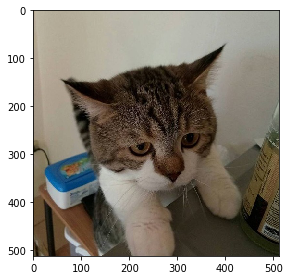

Input file size :  (512, 512)
Input file name :  kitty.jpg
Input Image Size :  79570


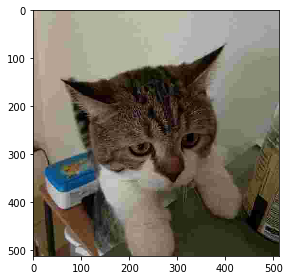

Output file size  :  (512, 512)
Output file name  :  Compressed_kitty.jpg
Output Image Size :  5336


In [4]:
from PIL import Image, ImageDraw, ImageFont
import os
from skimage import io

image_name_input = 'kitty.jpg'
im = Image.open(image_name_input)
io.imshow(image_name_input)
io.show()
print('Input file size : ', im.size)
print('Input file name : ', image_name_input)
print('Input Image Size : ', os.path.getsize(image_name_input))

image_name_output = 'Compressed_' + image_name_input
im.save(image_name_output, optimize=True, quality=10)
im2 = Image.open(image_name_output)
io.imshow(image_name_output)
io.show()

print('Output file size  : ', im2.size )
print('Output file name  : ', image_name_output)
print('Output Image Size : ', os.path.getsize(image_name_output))

Jpeg encoding


In [ ]:
import cv2
import numpy as np
import math

# import zigzag functions
from zigzag import *

# defining block size
block_size = 8

# reading image in grayscale
img = cv2.imread('pout.tif', 0)
cv2.imshow('input image', img)

# get size of the image
[h , w] = img.shape


##################### step 1 #####################
# compute number of blocks by diving height and width of image by block size

# you need to convert h and w to float to get the right number
h = np.float32(h)##### your code #####
w = np.float32(w)##### your code #####

# to cover the whole image the number of blocks should be ceiling of the division of image size by block size
# at the end convert it to int

# number of blocks in height
nbh = math.ceil(h/block_size)##### your code #####
nbh = np.int32(nbh)

# number of blocks in width
nbw = math.ceil(w/block_size)##### your code #####
nbw = np.int32(nbw)

##################### step 2 #####################
# Pad the image, because sometime image size is not dividable to block size
# get the size of padded image by multiplying block size by number of blocks in height/width

# height of padded image
H =  block_size * nbh##### your code #####

# width of padded image
W =  block_size * nbw##### your code #####

# create a numpy zero matrix with size of H,W
padded_img = np.zeros((H,W))

# copy the values of img  into padded_img[0:h,0:w]
for i in range(h):
        for j in range(w):
                pixel = img[i,j]
                padded_img[i,j] = pixel ##### your code #####

# or this other way here
#padded_img[0:h,0:w] = img[0:h,0:w]

cv2.imshow('input padded image', np.uint8(padded_img))

##################### step 3 #####################
# start encoding:
# divide image into block size by block size (here: 8-by-8) blocks
# To each block apply 2D discrete cosine transform
# reorder DCT coefficients in zig-zag order
# reshaped it back to block size by block size (here: 8-by-8)


# iterate over blocks
for i in range(nbh):
    
        # Compute start row index of the block
        row_ind_1 = i*block_size##### your code #####
        
        # Compute end row index of the block
        row_ind_2 = row_ind_1+block_size##### your code #####
        
        for j in range(nbw):
            
            # Compute start column index of the block
            col_ind_1 = j*block_size##### your code #####
            
            # Compute end column index of the block
            col_ind_2 = col_ind_1+block_size##### your code #####
            
            # select the current block we want to process using calculated indices
            block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ]
            
            # apply 2D discrete cosine transform to the selected block
            # you should use opencv dct function
            DCT = cv2.dct(block)##### your code #####
            
            # reorder DCT coefficients in zig zag order by calling zigzag function
            # it will give you a one dimentional array
            reordered = zigzag(DCT)##### your code #####
            
            # reshape the reorderd array back to (block size by block size) (here: 8-by-8)
            reshaped= np.reshape(reordered, (block_size, block_size))##### your code #####
            
            # copy reshaped matrix into padded_img on current block corresponding indices
            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped##### your code #####

cv2.imshow('encoded image', np.uint8(padded_img))

##################### step 4 #####################
# write h, w, block_size and padded_img into txt files at the end of encoding

# write padded_img into 'encoded.txt' file. You can use np.savetxt function.
np.savetxt('encoded.txt',padded_img)##### your code #####

# write [h, w, block_size] into size.txt. You can use np.savetxt function.
np.savetxt('size.txt',[h, w, block_size])##### your code #####

##################################################

cv2.waitKey(0)
cv2.destroyAllWindows()

Jpeg decoding

In [6]:
import cv2
import numpy as np
import math

# import zigzag functions
from zigzag import *

##################### step 5 #####################
# load h, w, block_size and padded_img from txt files

# load 'encoded.txt' into padded_img matrix.
# You should use np.loadtxt if you have already used np.savetxt to save them.
padded_img = np.loadtxt('encoded.txt')##### your code #####


# load 'size.txt' to get [h, w, block_size]
# You should use np.loadtxt if you have already used np.savetxt to save them.
[h, w, block_size] = np.loadtxt('size.txt')##### your code #####

##################### step 6 #####################
# get the size of padded_img
[H, W] = padded_img.shape##### your code #####

# compute number of blocks by diving height and width of image by block size
# copy from step 1
# number of blocks in height
nbh = math.ceil(h/block_size)##### your code #####
nbh = np.int32(nbh)

# number of blocks in width
nbw = math.ceil(w/block_size)##### your code #####
nbw = np.int32(nbw)

##################### step 7 #####################
# start decoding:
# divide encoded image into block size by block size (here: 8-by-8) blocks
# reshape it to one dimensional array (here: 64)
# use inverse zig-zag to reorder the array into a block
# apply 2D inverse discrete cosine transform


# iterate over blocks
for i in range(nbh):

        # Compute start row index of the block, same as encoder
        row_ind_1 = i*int(block_size)##### your code #####

        # Compute end row index of the block, same as encoder
        row_ind_2 = row_ind_1+int(block_size)##### your code #####

        for j in range(nbw):

            # Compute start column index of the block, same as encoder
            col_ind_1 = j*int(block_size)##### your code #####

            # Compute end column index of the block, same as encoder
            col_ind_2 = col_ind_1+int(block_size)##### your code #####

            # select the current block we want to process using calculated indices
            block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ]

            # reshape the 2D block (here: 8-by-8) to one dimensional array (here: 64)
            reshaped= np.reshape(block,(int(block_size)*int(block_size)))##### your code #####

            # use inverse_zigzag function to scan and reorder the array into a block
            reordered = inverse_zigzag(reshaped, int(block_size), int(block_size))##### your code #####

            # apply 2D inverse discrete cosine transform to the reordered matrix
            IDCT = cv2.idct(reordered)##### your code #####

            # copy IDCT matrix into padded_img on current block corresponding indices
            padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ] = IDCT##### your code #####


padded_img = np.uint8(padded_img)
cv2.imshow('decoded padded image', padded_img)

##################### step 8 #####################
# get the original size (h by w) image from padded_img

decoded_img = padded_img[0:int(h),0:int(w)]##### your code #####

cv2.imshow('decoded image', decoded_img)

##################################################

cv2.waitKey(0)
cv2.destroyAllWindows()

SyntaxError: ignored